# Simulating Montbrio Model

In [1]:
import os
import sys
import time
import timeit

import numpy as np
import scipy as sci
import seaborn as sns

In [2]:
import numba
from numba import jit, njit

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [4]:
%pylab inline
#%matplotlib notebook

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

Populating the interactive namespace from numpy and matplotlib


/home/meysam/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [8]:
Res_dir='Res_PhasePlane'

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $



In [9]:
def Montbrio_model(v0, r0, delta, eta, J, I_input, dt, sigma):
    
    nsteps=len(I_input)
    r, v= np.zeros(nsteps), np.zeros(nsteps)
    
    v_init, r_init=v0, r0
    v[0],r[0]=v_init, r_init
    
    for i in range(1, nsteps):
        dr =(delta/np.pi) +2*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        r[i]=(r[i-1] + dt * dr +np.sqrt(dt) *sigma * np.random.randn())
        v[i]=(v[i-1] + dt * dv +np.sqrt(dt) *sigma * np.random.randn())    
    
    return v,r

In [10]:
Montbrio_model_numba = numba.jit(Montbrio_model)

In [11]:
delta=0.7
eta=-4.6
J=14.5

In [12]:
dt = 0.001
t_init = 0.0
t_final = 100.0
nsteps = int((t_final - t_init)/dt)
Ts = np.arange(t_init,t_final,dt)

In [13]:
I0=3.
t0In=30
tn_In=60

I_input=[]
I_input = [0 for i in range(int((t0In - t_init)/dt))]+ [I0 for i in range(int((tn_In - t0In)/dt))]+ [0 for i in range(int((t_final - tn_In)/dt))]
I_input =np.asarray(I_input)

In [14]:
sigma=0.1

In [15]:
v0 = -3.
r0 = .5

In [16]:
start_time = time.time()

v,r = Montbrio_model(v0, r0, delta, eta, J, I_input, dt, sigma)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.763115644454956 seconds ---


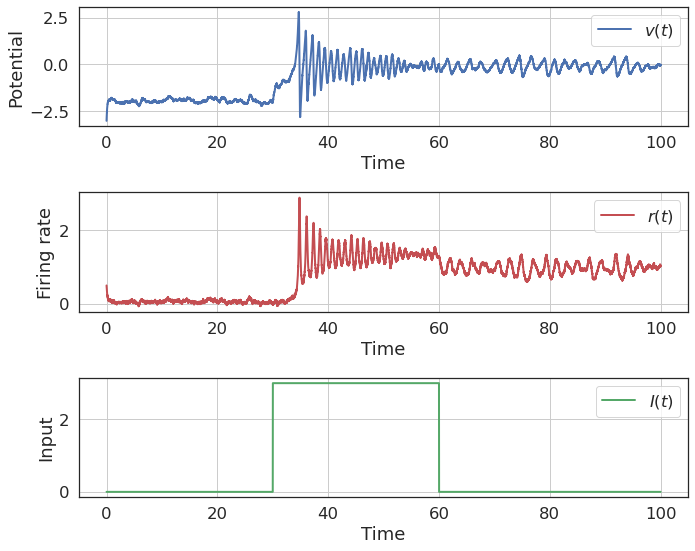

In [17]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(Ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Potential'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(312)
plt.plot(Ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time'); plt.ylabel('Firing rate'); 
plt.legend(loc='upper right')
plt.grid()

plt.subplot(313)
plt.plot(Ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time'); plt.ylabel('Input'); 
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_ode_Istep.png"), dpi=300)
plt.show()

### Linear Stability Analysis (LSA)

In [18]:
from MPR_NMM_LSA import *

In [19]:
scenarios = [
     {"delta":0.7, "eta":-4.6, "J":14.5, "I0":0.},
     {"delta":0.7, "eta":-0.7, "J":16.733, "I0":0.},
     {"delta":0.7, "eta":-7, "J":8.36, "I0":0.}
]

In [20]:
stability_lables=['bi-stable', 'stabel-focus', 'stable-node']

In [21]:
eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [22]:
eqnproot

{0: [[-0.0482872726554712, 2.307201339765533],
  [0.05712174222543427, -1.9503687356846853],
  [0.45231054025199185, -0.24630967056893854],
  [1.0080121529919428, -0.11052293351191098]],
 1: [[-0.07764559048755001, 1.4348330596080712],
  [1.6527732940434883, -0.06740698229202832]],
 2: [[-0.041065830278402715, 2.7129236011798965],
  [0.043178231629107264, -2.580199696951558]]}

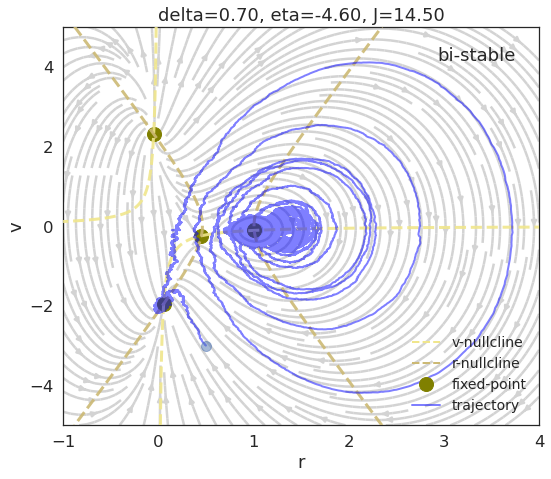

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
j=0
param=scenarios[j]
xrange = (-1, 4) 
yrange =(-5, 5)
v,r = Montbrio_model(v0, r0, param['delta'], param['eta'], param['J'], I_input, dt, sigma)
plot_vector_field(ax, param, xrange, yrange)
#plot_nullcline(ax, **param)
for i in range (len(eqnproot[j])):
    if i == len(eqnproot[j]) - 1:
        plt.plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3, label='fixed-point')
    else:
        plt.plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3)

plt.plot(r,v,  marker="o", markersize=0, lw=2, color='blue',  alpha=0.5, label='trajectory', zorder=4)
plt.plot(r[0],v[0],  marker="o", markersize=10, lw=0, color='b', alpha=0.5, zorder=5)

ax.set(xlabel='r', ylabel='v',  title="delta={:.2f}".format(param["delta"]) +", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
ax.legend(loc='lower right', frameon=False, fontsize=14)
text = 'bi-stable'
ax.text(0.95, 0.95, text, transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='top', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_bistable.png"), dpi=300)
plt.show()

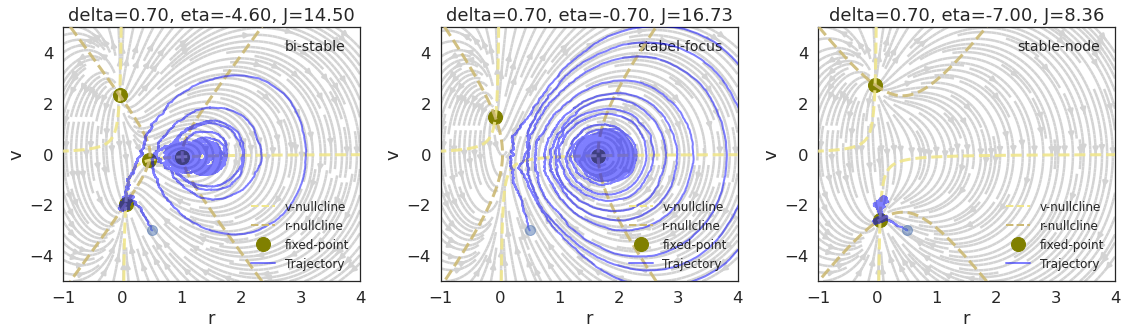

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for j in range(len(scenarios)):
    param=scenarios[j]
    xrange = (-1, 4) 
    yrange =(-5, 5)
    v,r = Montbrio_model(v0, r0, param['delta'], param['eta'], param['J'], I_input, dt, sigma)
    plot_vector_field(ax[j], param, xrange, yrange)
    #plot_nullcline(ax, **param)
 
    for i in range (len(eqnproot[j])):
        if i == len(eqnproot[j]) - 1:
            ax[j].plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3, label='fixed-point')
        else:
            ax[j].plot(eqnproot[j][i][0], eqnproot[j][i][1], marker="o", markersize=14, lw=0, color='olive', zorder=3)
   
    ax[j].plot(r,v,  marker="o", markersize=0, lw=2, color='blue', alpha=0.5, label='Trajectory', zorder=4)
    ax[j].plot(r[0],v[0],  marker="o", markersize=10, lw=0, color='b', alpha=0.5, zorder=5)
    
    ax[j].legend(loc='lower right', frameon=False, fontsize=12)
    ax[j].set(xlabel='r', ylabel='v',  title="delta={:.2f}".format(param["delta"]) +", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
    ax[j].text(0.95, 0.95, stability_lables[j], transform=ax[j].transAxes,
        horizontalalignment='right', verticalalignment='top', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_senarios.png"), dpi=300)
plt.show()

In [25]:
eqstability = {}
for i, param in enumerate(scenarios):
    print(i, eqnproot)
    eqstability[i] = []
    for e in eqnproot[i]:
        _ = Jacobian_Montbrio(e[0],e[1], **param)
        eqstability[i].append(stability(_))    
eqstability

0 {0: [[-0.0482872726554712, 2.307201339765533], [0.05712174222543427, -1.9503687356846853], [0.45231054025199185, -0.24630967056893854], [1.0080121529919428, -0.11052293351191098]], 1: [[-0.07764559048755001, 1.4348330596080712], [1.6527732940434883, -0.06740698229202832]], 2: [[-0.041065830278402715, 2.7129236011798965], [0.043178231629107264, -2.580199696951558]]}
1 {0: [[-0.0482872726554712, 2.307201339765533], [0.05712174222543427, -1.9503687356846853], [0.45231054025199185, -0.24630967056893854], [1.0080121529919428, -0.11052293351191098]], 1: [[-0.07764559048755001, 1.4348330596080712], [1.6527732940434883, -0.06740698229202832]], 2: [[-0.041065830278402715, 2.7129236011798965], [0.043178231629107264, -2.580199696951558]]}
2 {0: [[-0.0482872726554712, 2.307201339765533], [0.05712174222543427, -1.9503687356846853], [0.45231054025199185, -0.24630967056893854], [1.0080121529919428, -0.11052293351191098]], 1: [[-0.07764559048755001, 1.4348330596080712], [1.6527732940434883, -0.06740

{0: ['Unstable focus', 'Stable node', 'Saddle', 'Stable focus'],
 1: ['Unstable focus', 'Stable focus'],
 2: ['Unstable focus', 'Stable node']}

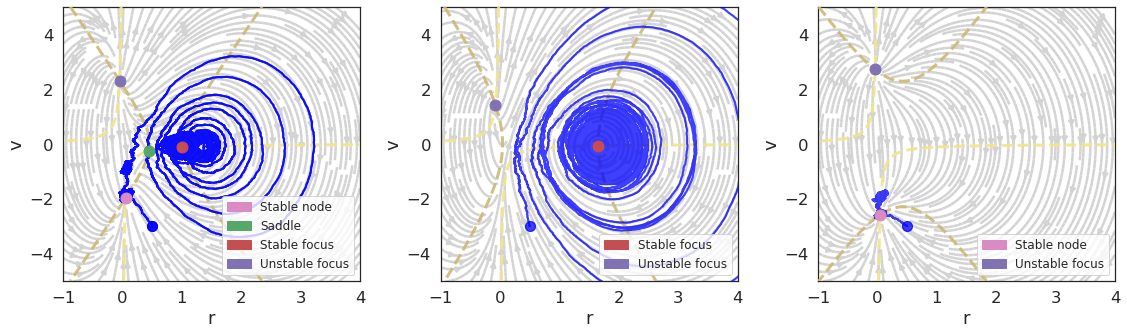

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, param in enumerate(scenarios):
    plot_phase_diagram(v0, r0, param, I_input, dt, sigma, ax[i])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_phaseplane_stablity_senarios.png"), dpi=300)
plt.show()

### Bifircation Diagram

In [27]:
eta_span = np.linspace(-15,0.,500)
J_span = np.linspace(.1,30,500)

In [28]:
stable_focus=[]
stable_node=[]
bi_stable = []
wierd=[]

for x,i in enumerate(eta_span):
    for y,j in enumerate(J_span):
        param =  {"delta":0.7, "eta":i, "J":j, "I0":0.}
        ro = find_roots(**param)
        stab = [stability(Jacobian_Montbrio(r,v, **param)) for r,v in ro]
        # Check how many of the equilibria is stable. 
        count_stab = np.sum(1 for item in stab if 'Stable' in item)
        if (count_stab) >= 2:
            bi_stable.append((i,j))
        else:     
            if stab.count('Stable focus') == 1:
                stable_focus.append((i,j))
            elif stab.count('Stable node') == 1:
                stable_node.append((i,j)) 
            else:     
                wierd.append((i,j))

In [29]:
wierd

[]

In [30]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

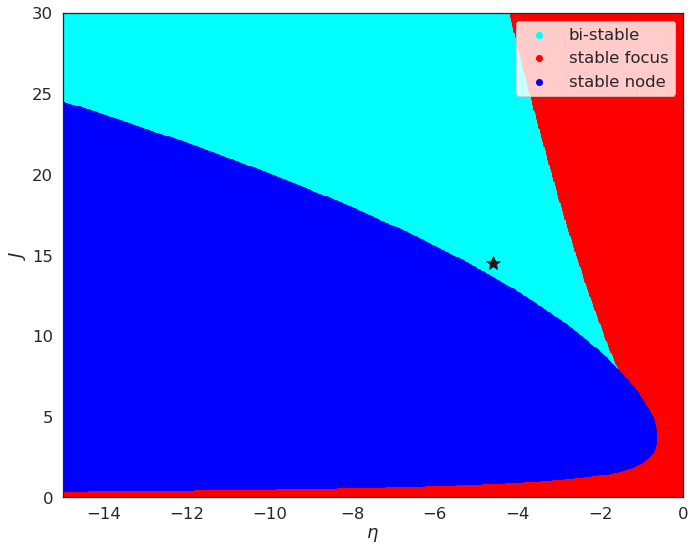

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*bi_stable), color='cyan', marker='o', label='bi-stable')
plt.scatter(*zip(*stable_focus), color='red', marker='o' ,label='stable focus')
plt.scatter(*zip(*stable_node), color='blue', marker='o', label='stable node')
plt.plot(eta_true, J_true, color='k', marker='*', markersize=14)
plt.xlabel('$\eta$'); plt.ylabel('$J$'); 
plt.legend(loc='upper right')
plt.xlim([-15, 0])
plt.ylim([0, 30])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_BifurcationDiagram.png"), dpi=300)
plt.show()

In [32]:
delta_span=np.linspace(.1,2.,50)
eta_span = np.linspace(-15,0.,50)
J_span = np.linspace(0.1,30,50)

In [33]:
stable_focus=[]
stable_node=[]
bi_stable = []
wierd=[]

for z, k in enumerate(delta_span):
    for x,i in enumerate(eta_span):
        for y,j in enumerate(J_span):
            param =  {"delta":k, "eta":i, "J":j, "I0":0.}
            ro = find_roots(**param)
            stab = [stability(Jacobian_Montbrio(r,v, **param)) for r,v in ro]
            # Check how many of the equilibria is stable. 
            count_stab = np.sum(1 for item in stab if 'Stable' in item)
            if (count_stab) >= 2:
                bi_stable.append((i/k,j/np.sqrt(k)))
            else:     
                if stab.count('Stable focus') == 1:
                    stable_focus.append((i/k,j/np.sqrt(k)))
                elif stab.count('Stable node') == 1:
                    stable_node.append((i/k,j/np.sqrt(k))) 
                else:     
                    wierd.append((i/k,j/np.sqrt(k)))


In [34]:
wierd

[]

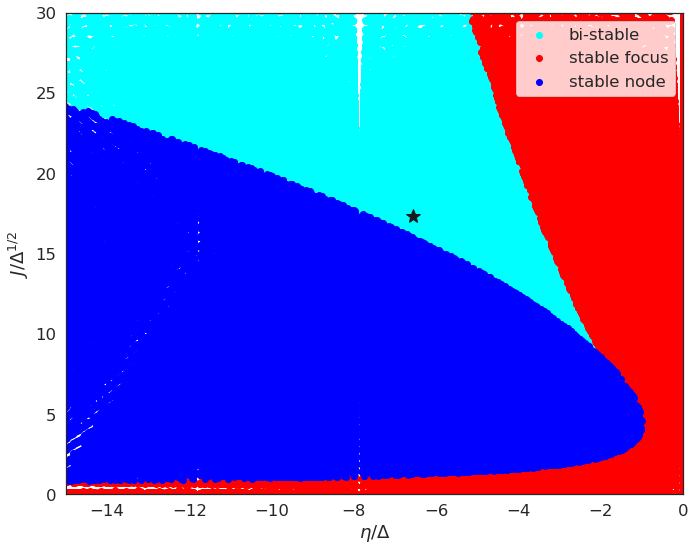

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*bi_stable), color='cyan', marker='o', label='bi-stable')
plt.scatter(*zip(*stable_focus), color='red', marker='o' ,label='stable focus')
plt.scatter(*zip(*stable_node), color='blue', marker='o', label='stable node')
plt.plot(eta_true/delta_true, J_true/np.sqrt(delta_true), color='k', marker='*', markersize=14)
plt.xlabel('$\eta/\Delta$'); plt.ylabel('$J/\Delta^{1/2}$'); 
plt.legend(loc='upper right')
plt.xlim([-15, 0])
plt.ylim([0, 30])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_BifurcationDiagramRatios.png"), dpi=300)
plt.show()